## Download data

In [76]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import eli5
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [77]:
ALICE_PATH = 'data/'

def load_alice_data(alice_path=ALICE_PATH):
    csv_path_train = os.path.join(alice_path, "train_sessions.csv")
    csv_path_test = os.path.join(alice_path, "test_sessions.csv")
    return pd.read_csv(csv_path_train, index_col='session_id', parse_dates=['time1']), \
            pd.read_csv(csv_path_test, index_col='session_id', parse_dates=['time1'])

df_train, df_test = load_alice_data()

In [78]:
hosts = pd.read_pickle('data/site_dic.pkl')

## Clean data

In [79]:
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # switch key and value

hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

hosts.drop(['name','split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True) # rename index for the future merge
df_train = pd.merge(df_train, hosts, how='left', on='site1')
df_test = pd.merge(df_test, hosts, how='left', on='site1')

In [80]:
df_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time7,site8,time8,site9,time9,site10,time10,target,len,domain
0,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4,com
1,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0,3,com
2,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0,3,com
3,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0,2,org
4,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0,3,com


In [81]:
df_test.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,len,domain
0,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,...,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00,3,com
1,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,...,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53,2,org
2,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,...,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36,3,com
3,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,...,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23,3,com
4,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,...,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44,4,fr


**First of all we should notice, that our data is time dependent. Leaving it shuffled will cause some problems later on during the cross-validation, so let's sort it right away.**

In [82]:
df_train = df_train.sort_values(by="time1")

**Now let's take a look at the column data types.**

In [83]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21668 to 204761
Data columns (total 23 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
len       253561 non-null int8
domain    253561 non-null object
dtypes: datetime64[ns](1), float64(9), int64(2), int8(1), object(10)
memory usage: 44.7+ MB


**It seems like only the first time column is in datetime format. Better convert the rest now, otherwise you'll have a problem with the datetime arithmetic, for example, when calculation session duration as a feature.**

In [84]:
for i in range(2, 11):
    df_train['time{}'.format(i)] = pd.to_datetime(df_train['time{}'.format(i)])
for i in range(2, 11):
    df_test['time{}'.format(i)] = pd.to_datetime(df_test['time{}'.format(i)])

## Pipeline configuration

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import pickle
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer

**The key idea here is to write your own classes for data transformation. They must follow a pretty simple template: they should inherit from two base classes – ``BaseEstimator``, ``TransformerMixin`` – and have a ``fit()`` and ``transform()`` methods, which take the dataset (X) as input and have a y value set to None. In pipelines the ``__init__()`` method is not neccessary.**

In [86]:
class DataPreparator(BaseEstimator, TransformerMixin):
    """
    Fill NaN with zero values.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        sites = ['site%s' % i for i in range(1, 11)]
        return X[sites].fillna(0).astype('int')

In [87]:
class ListPreparator(BaseEstimator, TransformerMixin):
    """
    Prepare a CountVectorizer friendly 2D-list from data.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.values.tolist()
        # Convert dataframe rows to strings
        return [" ".join([str(site) for site in row]) for row in X]

In [88]:
class ListPreparator_IDF(BaseEstimator, TransformerMixin):
    """
    Prepare a CountVectorizer friendly 2D-list from data.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        sites = ['site%s' % i for i in range(1, 11)]
        # read site -> id mapping provided by competition organizers 
        with open("data/site_dic.pkl", 'rb') as f:
            site2id = pickle.load(f)
        # create an inverse id _> site mapping
        id2site = {v:k for (k, v) in site2id.items()}
        # we treat site with id 0 as "unknown"
        id2site[0] = 'unknown'
        X = X[sites].apply(lambda row:' '.join([id2site[i] for i in row]), axis=1).tolist()
        # Convert dataframe rows to strings
        return X

In [193]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new attributes to training and test set.
    """
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        times = ['time%s' % i for i in range(1, 11)]
        # intraday features
        hour = X['time1'].apply(lambda ts: ts.hour)
        morning = ((hour >= 7) & (hour <= 11)).astype('int')
        day = ((hour >= 12) & (hour <= 18)).astype('int')
        evening = ((hour >= 19) & (hour <= 23)).astype('int')
        night = ((hour >= 0) & (hour <=6)).astype('int')
        
        # season features
        month = X['time1'].apply(lambda ts: ts.month)
        summer = ((month >= 6) & (month <= 8)).astype('int')
        
        # day of the week features
        dow = X['time1'].apply(lambda ts: ts.weekday()).astype('int')
        
        # year features
        year = X['time1'].apply(lambda ts: ts.year).astype('int')
        
        # is that a working hour or not
        work_hours = X[times].min(axis=1).apply(lambda ts: 1 if (ts.date().weekday() in (0,1,2,3)) &
                                             ((ts.hour>=8)&(ts.hour<=17)&(ts.hour!=12)) else 0)
        mon = X['time1'].apply(lambda ts: ts.dayofweek in [0]).astype(np.int8) # monday
        wen = X['time1'].apply(lambda ts: ts.dayofweek in [2]).astype(np.int8) # wensday
        fri = X['time1'].apply(lambda ts: ts.dayofweek in [5]).astype(np.int8) # friday
        sun = X['time1'].apply(lambda ts: ts.dayofweek in [6]).astype(np.int8) # sunday
        hour_14 = (hour==14).astype('int')
        hour_11 = (hour==11).astype('int')
        hour_9  =  (hour==9).astype('int')
        month_9 = (month == 9).astype('int')
        year_month = X['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
        weekend = X['time1'].apply(lambda ts: ts.dayofweek > 5).astype(np.int8)
        X = np.c_[morning.values, day.values, evening.values, summer.values,
                  dow.values, year.values, night.values, hour_14.values,
                  hour_11.values, hour_9.values, weekend.values, month_9.values]
        return X

In [194]:
class ScaledAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new features, that should be scaled.
    """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # session time features
        times = ['time%s' % i for i in range(1, 11)]
        # session duration: take to the power of 1/5 to normalize the distribution
        session_duration = (X[times].max(axis=1) -
                            X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2
        # number of sites visited in a session
        number_of_sites = X[times].isnull().sum(axis=1).apply(lambda x: 10 - x)
        # average time spent on one site during a session
        time_per_site = (session_duration / number_of_sites) ** 0.2
        dow = X['time1'].apply(lambda ts: ts.weekday()).astype('int')
        lengtch = X['len'].astype('int')
        #poly = PolynomialFeatures(2).fit_transform(dow.values.reshape(-1, 1), session_duration.values.reshape(-1, 1))
        X = np.c_[session_duration.values, time_per_site.values,lengtch.values]
        return X

In [195]:
vectorizer_pipeline = Pipeline([
    ("preparator", DataPreparator()),
    ("list_preparator", ListPreparator()),
    ("vectorizer", CountVectorizer(ngram_range=(1, 5), max_features=50000,tokenizer= lambda s: s.split()))
])

attributes_pipeline = Pipeline([
    ("adder", AttributesAdder())
])
  
scaled_attributes_pipeline = Pipeline([
    ("adder", ScaledAttributesAdder()),
    ("scaler", StandardScaler())
])

**Finally you can combine these pipelines using ``FeatureUnion()`` class, which will merge the resulting datasets from each pipeline. **

In [196]:
full_pipeline = FeatureUnion(transformer_list=[
('vectorizer_pipeline', vectorizer_pipeline),
('attributes_pipeline', attributes_pipeline),
('scaled_attributes_pipeline', scaled_attributes_pipeline)
])

**All you need to do at the end, is just call ``fit_transform()`` or ``transform()`` methods on the ``full_pipeline`` and pass them your original datasets.**

In [197]:
X_train = full_pipeline.fit_transform(df_train)
X_test = full_pipeline.transform(df_test)

y_train = df_train["target"].astype('int').values

## Cross-validation and submitting results

In [198]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt

**As @yorko introduced, we use time-aware cross-validation scheme.**

In [199]:
#35.93813663804626
logit = LogisticRegression(C=35.93813663804626, random_state=42, solver='liblinear',n_jobs=-1)

In [ ]:
time_split = TimeSeriesSplit(n_splits=10)

In [24]:
#0.924069545700732
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                        scoring='roc_auc', n_jobs=-1)

cv_scores.mean()

/home/michael/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/michael/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/michael/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/michael/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/home/michael/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logisti

0.9334935569108783

**Finally, train your model on the whole train set and write a function for submitting results.**

In [200]:
logit.fit(X_train, y_train)

LogisticRegression(C=35.93813663804626, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [201]:
logit.score(X_train, y_train)

0.9953581189536246

In [202]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [203]:
logit_test_pred = logit.predict_proba(X_test)[:, 1]

write_to_submission_file(logit_test_pred, 'submit.csv') #  0.95755

# Hyperparamet tunning

In [187]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [188]:
%time
logit_grid_searcher.fit(X_train, y_train)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.9 µs
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise',
       estimator=LogisticRegression(C=35.93813663804626, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-02, 1.62378e-02, 2.63665e-02, 4.28133e-02, 6.95193e-02,
       1.12884e-01, 1.83298e-01, 2.97635e-01, 4.83293e-01, 7.84760e-01,
       1.27427e+00, 2.06914e+00, 3.35982e+00, 5.45559e+00, 8.85867e+00,
       1.43845e+01, 2.33572e+01, 3.79269e+01, 6.15848e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [189]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9335625222057611, {'C': 1.2742749857031335})

In [190]:
logit_test_pred = logit_grid_searcher.predict_proba(X_test)[:, 1]

In [191]:
write_to_submission_file(logit_test_pred, 'final_submit.csv')

# Validation and Learning Curves

In [96]:
logit_pipe = Pipeline([('logit', logit)])
val_train, val_test = validation_curve(logit_pipe, X_train, y_train,
                                       'logit__C', c_values, cv=time_split,
                                        scoring='roc_auc',verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.2min finished


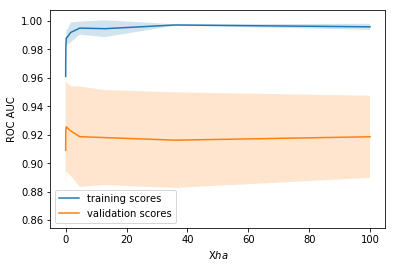

In [101]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(c_values, val_train, label='training scores')
plot_with_err(c_values, val_test, label='validation scores')
plt.xlabel(r'$Χha$'); plt.ylabel('ROC AUC')
plt.legend();

In [111]:
def plot_learning_curve(degree=2, C=0.20344246900318834):
    train_sizes = np.linspace(0.05, 1, 5)
    logit_pipe = Pipeline([('logit', logit)])
    N_train, val_train, val_test = learning_curve(logit_pipe,
                                                  X_train, y_train, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc',verbose=1, n_jobs=-1)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()

[learning_curve] Training set sizes: [ 10142  58318 106495 154671 202848]


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.1min finished


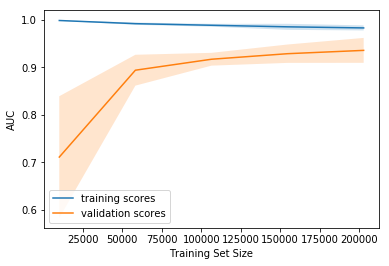

In [112]:
plot_learning_curve(degree=2, C=0.20344246900318834)